In [1]:
import os
import sys

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchmetrics import Accuracy
from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torch import tensor
from sklearn.metrics import classification_report, confusion_matrix

from experience_dataset import ExperienceDataset

In [2]:
data_directory = '/Users/mattn/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofFlorida/BME 4883 Spring 2024 - Team 01 - Intubator Trainers - Appendix A4 - Raw Data & Design Verification/Processed'

data_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
"""
# Initialize empty lists to store novices and experts data
novices_data = []
experts_data = []

# Iterate over each CSV file and load it into a DataFrame
for file in data_files:
    df = pd.read_csv(os.path.join(data_directory, file))
    # Extract expertise level and trial from filename
    expertise_level, trial = file.split('_')[:2]  # Assuming filename format: novice_trialX.csv or expert_trialX.csv
#    df['expertise_level'] = expertise_level
    df['trial'] = trial
    if expertise_level == 'novice':
        df['expertise_level'] = 0
        novices_data.append(df)
    elif expertise_level == 'expert':
        df['expertise_level'] = 1
        experts_data.append(df)

# Concatenate novices and experts DataFrames
novices_data = pd.concat(novices_data, ignore_index=True)
experts_data = pd.concat(experts_data, ignore_index=True)
"""
sequences = []
max_rows = 0

for file in data_files:
    df = pd.read_csv(os.path.join(data_directory, file))
    expertise_level, trial = file.split('_')[:2]  # Assuming filename format: novice_trialX.csv or expert_trialX.csv
   # df['trial'] = trial
    if expertise_level == 'novice':
        label = 0
    elif expertise_level == 'expert':
        label = 1
    
    desired_rows = 299

    # Calculate the number of rows to be padded
    rows_to_pad = desired_rows - df.shape[0]

    # Pad the end of the array with zero rows
    zero_rows_df = pd.DataFrame([[0] * len(df.columns)] * rows_to_pad, columns=df.columns)
    
    # Concatenate the original DataFrame with the zero-padded DataFrame
    padded_df = pd.concat([df, zero_rows_df], ignore_index=True)
    
    sequences.append((padded_df,label))
    

In [3]:
'''
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(combined_data['trial'])
label_encoder.classes_

combined_data['trial'] = encoded_labels

'''

"\nlabel_encoder = LabelEncoder()\nencoded_labels = label_encoder.fit_transform(combined_data['trial'])\nlabel_encoder.classes_\n\ncombined_data['trial'] = encoded_labels\n\n"

In [126]:
train_sequence, test_sequence = train_test_split(sequences, test_size=.2, random_state = 42)

In [5]:
'''
class ExperienceDataset(Dataset):
    
    def __init__(self,sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )
'''

'\nclass ExperienceDataset(Dataset):\n    \n    def __init__(self,sequences):\n        self.sequences = sequences\n        \n    def __len__(self):\n        return len(self.sequences)\n    \n    def __getitem__(self, idx):\n        sequence, label = self.sequences[idx]\n        return dict(\n            sequence = torch.Tensor(sequence.to_numpy()),\n            label = torch.tensor(label).long()\n        )\n'

In [110]:
class ExperienceDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = ExperienceDataset(self.train_sequences)
        self.test_dataset = ExperienceDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = True,
            num_workers = cpu_count()
        )
    
    def val_dataLoader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )
    
    def test_dataLoader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )

In [111]:
N_EPOCHS = 250
BATCH_SIZE = 32

data_module = ExperienceDataModule(train_sequence, test_sequence, BATCH_SIZE)

In [150]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_features, n_classes, n_hidden=512, n_layers=5):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            batch_first = True,
            dropout = .75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        _, (hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        return self.classifier(out)
            

In [151]:
class ExperiencePredictor(pl.LightningModule):
    
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = Accuracy(task='binary')
        step_accuracy = accuracy(predictions, labels)
        
        self.log('training_loss', loss, prog_bar=True, logger=True)
        self.log('training_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = Accuracy(task='binary')
        step_accuracy = accuracy(predictions, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def testing_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        accuracy = Accuracy(task='binary')
        step_accuracy = accuracy(predictions, labels)
        
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.0001)
        

In [153]:
model = ExperiencePredictor(
    n_features=10, 
    n_classes=2
)

In [154]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18941), started 1 day, 4:38:59 ago. (Use '!kill 18941' to kill it.)

In [155]:
checkpoint_filepath = '/Users/mattn/Library/CloudStorage/OneDrive-UniversityofFlorida/Senior-Design'
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_filepath,
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min',
    save_last=True
    
)

logger = TensorBoardLogger('lightning_logs', name='experience')

trainer = pl.Trainer(
    logger = logger,
    callbacks = [checkpoint_callback],
    max_epochs = N_EPOCHS,
    log_every_n_steps=2
 #   gpus=1,
    #progress_bar_refresh_rate=30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

/Users/mattn/anaconda3/envs/python39/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/mattn/anaconda3/envs/python39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /Users/mattn/Library/CloudStorage/OneDrive-UniversityofFlorida/Senior-Design exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 9.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.917    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 2: 'val_loss' was not in top 2
Epoch 1, global step 4: 'val_loss' was not in top 2
Epoch 2, global step 6: 'val_loss' was not in top 2
Epoch 3, global step 8: 'val_loss' was not in top 2
Epoch 4, global step 10: 'val_loss' was not in top 2
Epoch 5, global step 12: 'val_loss' was not in top 2
Epoch 6, global step 14: 'val_loss' was not in top 2
Epoch 7, global step 16: 'val_loss' was not in top 2
Epoch 8, global step 18: 'val_loss' was not in top 2
Epoch 9, global step 20: 'val_loss' was not in top 2
Epoch 10, global step 22: 'val_loss' was not in top 2
Epoch 11, global step 24: 'val_loss' was not in top 2
Epoch 12, global step 26: 'val_loss' was not in top 2
Epoch 13, global step 28: 'val_loss' was not in top 2
Epoch 14, global step 30: 'val_loss' was not in top 2
Epoch 15, global step 32: 'val_loss' was not in top 2
Epoch 16, global step 34: 'val_loss' was not in top 2
Epoch 17, global step 36: 'val_loss' was not in top 2
Epoch 18, global step 38: 'val_loss' was n

In [124]:
trained_model = ExperiencePredictor.load_from_checkpoint(
    trainer.checkpoint_callback.last_model_path,
    n_features = 10,
    n_classes = 2
)

In [128]:
test_dataset = ExperienceDataset(test_sequence)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']
    _, output = trained_model(sequence.unsqueeze(dim=0))
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())
    

  0%|          | 0/11 [00:00<?, ?it/s]

In [145]:
print(
    classification_report(labels, predictions, target_names=['Novice', 'Expert'])
)

              precision    recall  f1-score   support

      Novice       0.00      0.00      0.00         5
      Expert       0.55      1.00      0.71         6

    accuracy                           0.55        11
   macro avg       0.27      0.50      0.35        11
weighted avg       0.30      0.55      0.39        11



/Users/mattn/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattn/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mattn/anaconda3/envs/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [141]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Experience')
    plt.xlabel('Predicted Experience')

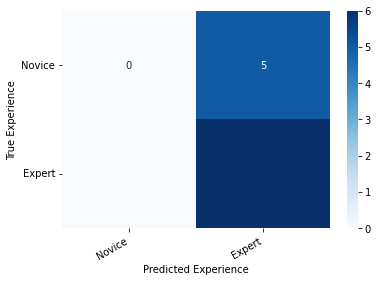

In [148]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index=['Novice', 'Expert'], columns=['Novice', 'Expert']
)
show_confusion_matrix(df_cm)

In [123]:
trainer.checkpoint_callback.last_model_path

'/Users/mattn/Library/CloudStorage/OneDrive-UniversityofFlorida/Senior-Design/last.ckpt'

In [144]:
print(test_sequence)

[(        x-pos     y-pos     z-pos   w-orien   x-orien   y-orien   z-orien  \
0    0.000000  0.000000  0.000000  0.690369  0.581277 -0.316564 -0.292054   
1    0.000005  0.073661  0.048146  0.772311  0.417842 -0.227714 -0.420820   
2    0.024052  0.107857  0.154204  0.908511  0.100324 -0.157375 -0.373867   
3    0.101274  0.082174  0.194924  0.737206 -0.392653 -0.349406 -0.424579   
4    0.178466  0.011325  0.234495  0.715431 -0.541170 -0.174592 -0.405970   
..        ...       ...       ...       ...       ...       ...       ...   
294  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
295  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
296  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
297  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
298  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         x-ang      y-ang      z-ang  
0   -34.119000  -7.019000  19.2870

In [149]:
print(predictions)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
